In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # constants
    r"\gamma^i": "gammai",
    r"\gamma^h": "gammah",
    r"\rho^i": "rhoi",
    r"\rho^h": "rhoh",
    r"\sigma^a": "siga",
    r"\sigma^{a}": "siga",
    r"\mu^a": "mua",
    r"\mu^O": "muO",
    r"\zeta^i": "zetai",
    r"\zeta^h": "zetah",
    r"\alpha^a": "aa",
    r"\kappa": "kappa",

    # state variables
    r"\eta_t": "eta",

    # learnable variables (agents + endogenous variables)
    r"\xi_t^i": "xii",
    r"\xi_t^h": "xih",
    r"\mu_t^{\eta}": "mue",
    r"\sigma_t^{\eta a}": "sigea",
    r"q_t^a": "qa",
    r"w_t^{ia}": "wia",
    r"w_t^{ha}": "wha",

    # variables defined by equations
    r"\iota_t^a": "iota_a",
    r"\Phi_t^a": "phi_a",
    r"c_t^i": "ci",
    r"c_t^h": "ch",
    r"\sigma^{qa}": "sigqa",
    r"\sigma_t^{qa}": "sigqa",
    r"\sigma_t^{nia}": "signia",
    r"\sigma_t^{nha}": "signha",
    r"\sigma_t^{\xi ia}": "sigxia",
    r"\sigma_t^{\xi ha}": "sigxha",
    r"\sigma_t^{na}": "signa",
    r"\mu_t^{qa}": "muqa",
    r"\hat{r_t^{ka}}": "rka_hat", # define hat first, and replace hat first
    r"r_t^{ka}": "rka",
    r"\mu_t^{ni}": "muni",
    r"\mu_t^{nh}": "munh",
    r"\mu_t^{\xi i}": "muxi",
    r"\mu_t^{\xi h}": "muxh",
}

In [3]:
set_seeds(0)
pde_model = PDEModel("problem1", {
        "sampling_method": SamplingMethod.FixedGrid,
        "num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam,
        "loss_soft_attention": True}, latex_var_mapping)
pde_model.set_state(["eta"], {"eta": [0.01, 0.99]})
pde_model.add_agents(["xii", "xih"], {"xii": {"positive": True}, "xih": {"positive": True}})
pde_model.add_endogs(["mue", "qa", "wia", "wha", "sigea"], {"qa": {"positive": True}})
pde_model.add_params({
    "gammai": 2.0,
    "gammah": 5.0,
    "rhoi": 0.05,
    "rhoh": 0.05,
    "siga": 0.2, #\sigma^{a}
    "mua": 0.04,
    "muO": 0.04,
    "zetai":1.00005,
    "zetah":1.00005,
    "aa":0.1,
    "kappa":10000
})
pde_model.add_equation(r"$\iota_t^a = \frac{q_t^a - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi_t^a = \frac{1}{\kappa} * \log(1+\kappa * \iota_t^a)$")
pde_model.add_equation(r"$c_t^i = (\rho^i)^{\zeta^i} * (\xi_t^i)^{1-\zeta^i}$")
pde_model.add_equation(r"$c_t^h = (\rho^h)^{\zeta^h} * (\xi_t^h)^{1-\zeta^h}$")
pde_model.add_equation(r"$\sigma_t^{qa} = \frac{1}{q_t^a}  * \frac{\partial q_t^a}{\partial \eta_t}  * \sigma_t^{\eta a}  * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{nia} = w_t^{ia}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{nha} = w_t^{ha}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{\xi ia}  = \frac{1}{\xi_t^i} * \frac{\partial \xi_t^i}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{\xi ha}  = \frac{1}{\xi_t^h} * \frac{\partial \xi_t^h}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{na} = \eta_t * \sigma_t^{nia} + (1-\eta_t) * \sigma_t^{nha}$")
pde_model.add_equation(r"$\mu_t^{qa} = \frac{1}{q_t^a}  * \left(\frac{\partial q_t^a}{\partial \eta_t}  * \mu_t^{\eta}  * \eta_t + \frac{1}{2}  * \frac{\partial^2 q_t^a}{\partial \eta_t^2}  * (\sigma_t^{\eta a}  * \eta_t)^2\right)$")
pde_model.add_equation(r"$r_t^{ka} = \mu_t^{qa} + \mu^a + \Phi_t^a + \sigma^a * \sigma^{qa} + \frac{\alpha^a - \iota_t^a}{q_t^a}$")
pde_model.add_equation(r"$r_t = r_t^{ka} - \gamma^h * w_t^{ha} * (\sigma^a + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\mu_t^{ni} = r_t - c_t^i + w_t^{ia} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{nh} = r_t - c_t^h + w_t^{ha} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{\xi i} = \frac{1}{\xi_t^i} * \left(\frac{\partial \xi_t^i}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^i}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\mu_t^{\xi h} = \frac{1}{\xi_t^h} * \left(\frac{\partial \xi_t^h}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^h}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\hat{r_t^{ka}} = r_t^{ka} + \frac{\mu^O - \mu^a}{\sigma^a} * (\sigma^a + \sigma_t^{qa})$")

pde_model.add_endog_equation(r"$\mu_t^{\eta} = (1-\eta_t) * (\mu_t^{ni} - \mu_t^{nh}) +(\sigma_t^{na})^2  - \sigma_t^{nia} * \sigma_t^{na}$")
pde_model.add_endog_equation(r"$\sigma_t^{\eta a} = (1-\eta_t) * (\sigma_t^{nia} - \sigma_t^{nha})$")
pde_model.add_endog_equation(r"$\hat{r_t^{ka}} - r_t = \gamma^i * w_t^{ia} * (\sigma^a  + \sigma_t^{qa})^2 - (1-\gamma^i) * \sigma_t^{\xi ia} * (\sigma^{a}  + \sigma_t^{qa})$")
# pde_model.add_endog_equation(r"$r_t^{ka} - r_t = \gamma^h * w_t^{ha} * (\sigma^a  + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^{a}  + \sigma_t^{qa})$")
pde_model.add_endog_equation(r"$1 = w_t^{ia} * \eta_t + w_t^{ha} * (1-\eta_t)$")
pde_model.add_endog_equation(r"$\alpha^a - \iota_t^a = (c_t^i*\eta_t + c_t^h * (1 - \eta_t)) * q_t^a$")

pde_model.add_hjb_equation(r"$\frac{\rho^i}{1-\frac{1}{\zeta^i}} * \left( \left(\frac{c_t^i}{\xi_t^i} \right)^{1-1/\zeta^i}-1 \right) + \mu_t^{\xi i} +  \mu_t^{ni} - \frac{\gamma^i}{2} * (\sigma_t^{nia})^2  - \frac{\gamma^i}{2} * (\sigma_t^{\xi ia})^2 + (1-\gamma^i) * \sigma_t^{\xi ia} * \sigma_t^{nia}$")
pde_model.add_hjb_equation(r"$\frac{\rho^h}{1-\frac{1}{\zeta^h}} * \left( \left(\frac{c_t^h}{\xi_t^h} \right)^{1-1/\zeta^h}-1 \right) + \mu_t^{\xi h} +  \mu_t^{nh} - \frac{\gamma^h}{2} * (\sigma_t^{nha})^2  - \frac{\gamma^h}{2} * (\sigma_t^{\xi ha})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * \sigma_t^{nha}$")

print(pde_model)
if not os.path.exists("./models/1d_prob_soft_attention/model.pt"):
    pde_model.train_model("./models/1d_prob_soft_attention", "model.pt", True)
    pde_model.load_model(torch.load("./models/1d_prob_soft_attention/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/1d_prob_soft_attention/model_best.pt"))
    pde_model.eval_model(True)

===========================Summary of Model problem1============================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": true
}
Latex Variable Mapping:
{
 "\\gamma^i": "gammai",
 "\\gamma^h": "gammah",
 "\\rho^i": "rhoi",
 "\\rho^h": "rhoh",
 "\\sigma^a": "siga",
 "\\sigma^{a}": "siga",
 "\\mu^a": "mua",
 "\\mu^O": "muO",
 "\\zeta^i": "zetai",
 "\\zeta^h": "zetah",
 "\\alpha^a": "aa",
 "\\kappa": "kappa",
 "\\eta_t": "eta",
 "\\xi_t^i": "xii",
 "\\xi_t^h": "xih",
 "\\mu_t^{\\eta}": "mue",
 "\\sigma_t^{\\eta a}": "sigea",
 "q_t^a": "qa",
 "w_t^{ia}": "wia",
 "w_t^{ha}": "wha",
 "\\iota_t^a": "iota_a",
 "\\Phi_t^a": "phi_a",
 "c_t^i": "ci",
 "c_t^h": "ch",
 "\\sigma^{qa}": "sigqa",
 "\\sigma_t^{qa}": "sigqa",
 "\\s

Total loss: 0.0000: 100%|██████████| 2000/2000 [01:53<00:00, 17.57it/s]


training finished, total time :: 113.86498141288757
Best model saved to ./models/1d_prob_soft_attention/model_best.pt if valid
Model saved to ./models/1d_prob_soft_attention/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
endogeq_4: 0.0000,
endogeq_5: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
total_loss: 0.0000


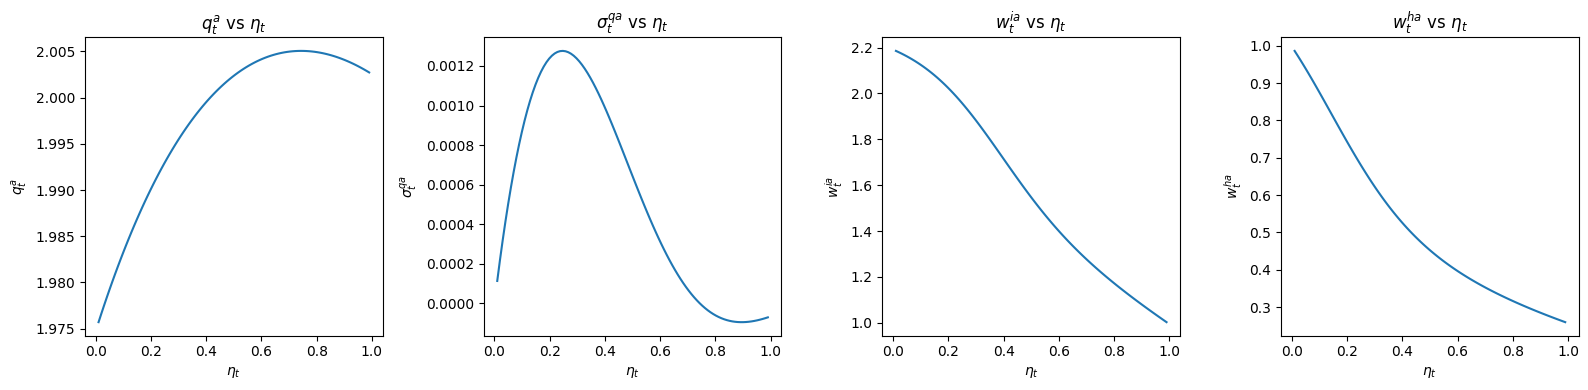

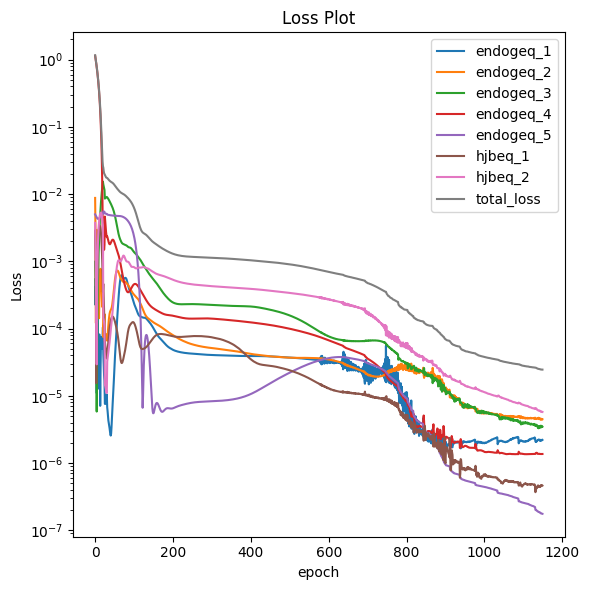

In [4]:
pde_model.plot_vars([r"$q_t^a$", r"$\sigma_t^{qa}$", r"$w_t^{ia}$", r"$w_t^{ha}$"])
plot_loss_df(fn="./models/1d_prob_soft_attention/model_min_loss.csv", loss_plot_fn="./models/1d_prob_soft_attention/model_min_loss.png")

In [5]:
set_seeds(0)
pde_model = PDEModel("problem1", {
        "sampling_method": SamplingMethod.FixedGrid,
        "num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam,
        "loss_balancing": True, "bernoulli_prob": 0.9, "loss_balancing_temp": 0.1, "loss_balancing_alpha": 0.9}, latex_var_mapping)
pde_model.set_state(["eta"], {"eta": [0.01, 0.99]})
pde_model.add_agents(["xii", "xih"], {"xii": {"positive": True}, "xih": {"positive": True}})
pde_model.add_endogs(["mue", "qa", "wia", "wha", "sigea"], {"qa": {"positive": True}})
pde_model.add_params({
    "gammai": 2.0,
    "gammah": 5.0,
    "rhoi": 0.05,
    "rhoh": 0.05,
    "siga": 0.2, #\sigma^{a}
    "mua": 0.04,
    "muO": 0.04,
    "zetai":1.00005,
    "zetah":1.00005,
    "aa":0.1,
    "kappa":10000
})
pde_model.add_equation(r"$\iota_t^a = \frac{q_t^a - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi_t^a = \frac{1}{\kappa} * \log(1+\kappa * \iota_t^a)$")
pde_model.add_equation(r"$c_t^i = (\rho^i)^{\zeta^i} * (\xi_t^i)^{1-\zeta^i}$")
pde_model.add_equation(r"$c_t^h = (\rho^h)^{\zeta^h} * (\xi_t^h)^{1-\zeta^h}$")
pde_model.add_equation(r"$\sigma_t^{qa} = \frac{1}{q_t^a}  * \frac{\partial q_t^a}{\partial \eta_t}  * \sigma_t^{\eta a}  * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{nia} = w_t^{ia}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{nha} = w_t^{ha}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{\xi ia}  = \frac{1}{\xi_t^i} * \frac{\partial \xi_t^i}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{\xi ha}  = \frac{1}{\xi_t^h} * \frac{\partial \xi_t^h}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{na} = \eta_t * \sigma_t^{nia} + (1-\eta_t) * \sigma_t^{nha}$")
pde_model.add_equation(r"$\mu_t^{qa} = \frac{1}{q_t^a}  * \left(\frac{\partial q_t^a}{\partial \eta_t}  * \mu_t^{\eta}  * \eta_t + \frac{1}{2}  * \frac{\partial^2 q_t^a}{\partial \eta_t^2}  * (\sigma_t^{\eta a}  * \eta_t)^2\right)$")
pde_model.add_equation(r"$r_t^{ka} = \mu_t^{qa} + \mu^a + \Phi_t^a + \sigma^a * \sigma^{qa} + \frac{\alpha^a - \iota_t^a}{q_t^a}$")
pde_model.add_equation(r"$r_t = r_t^{ka} - \gamma^h * w_t^{ha} * (\sigma^a + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\mu_t^{ni} = r_t - c_t^i + w_t^{ia} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{nh} = r_t - c_t^h + w_t^{ha} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{\xi i} = \frac{1}{\xi_t^i} * \left(\frac{\partial \xi_t^i}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^i}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\mu_t^{\xi h} = \frac{1}{\xi_t^h} * \left(\frac{\partial \xi_t^h}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^h}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\hat{r_t^{ka}} = r_t^{ka} + \frac{\mu^O - \mu^a}{\sigma^a} * (\sigma^a + \sigma_t^{qa})$")

pde_model.add_endog_equation(r"$\mu_t^{\eta} = (1-\eta_t) * (\mu_t^{ni} - \mu_t^{nh}) +(\sigma_t^{na})^2  - \sigma_t^{nia} * \sigma_t^{na}$")
pde_model.add_endog_equation(r"$\sigma_t^{\eta a} = (1-\eta_t) * (\sigma_t^{nia} - \sigma_t^{nha})$")
pde_model.add_endog_equation(r"$\hat{r_t^{ka}} - r_t = \gamma^i * w_t^{ia} * (\sigma^a  + \sigma_t^{qa})^2 - (1-\gamma^i) * \sigma_t^{\xi ia} * (\sigma^{a}  + \sigma_t^{qa})$")
# pde_model.add_endog_equation(r"$r_t^{ka} - r_t = \gamma^h * w_t^{ha} * (\sigma^a  + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^{a}  + \sigma_t^{qa})$")
pde_model.add_endog_equation(r"$1 = w_t^{ia} * \eta_t + w_t^{ha} * (1-\eta_t)$")
pde_model.add_endog_equation(r"$\alpha^a - \iota_t^a = (c_t^i*\eta_t + c_t^h * (1 - \eta_t)) * q_t^a$")

pde_model.add_hjb_equation(r"$\frac{\rho^i}{1-\frac{1}{\zeta^i}} * \left( \left(\frac{c_t^i}{\xi_t^i} \right)^{1-1/\zeta^i}-1 \right) + \mu_t^{\xi i} +  \mu_t^{ni} - \frac{\gamma^i}{2} * (\sigma_t^{nia})^2  - \frac{\gamma^i}{2} * (\sigma_t^{\xi ia})^2 + (1-\gamma^i) * \sigma_t^{\xi ia} * \sigma_t^{nia}$")
pde_model.add_hjb_equation(r"$\frac{\rho^h}{1-\frac{1}{\zeta^h}} * \left( \left(\frac{c_t^h}{\xi_t^h} \right)^{1-1/\zeta^h}-1 \right) + \mu_t^{\xi h} +  \mu_t^{nh} - \frac{\gamma^h}{2} * (\sigma_t^{nha})^2  - \frac{\gamma^h}{2} * (\sigma_t^{\xi ha})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * \sigma_t^{nha}$")

print(pde_model)
if not os.path.exists("./models/1d_prob_relobralo/model.pt"):
    pde_model.train_model("./models/1d_prob_relobralo", "model.pt", True)
    pde_model.load_model(torch.load("./models/1d_prob_relobralo/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/1d_prob_relobralo/model_best.pt"))
    pde_model.eval_model(True)

===========================Summary of Model problem1============================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": true,
 "bernoulli_prob": 0.9,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.9,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\gamma^i": "gammai",
 "\\gamma^h": "gammah",
 "\\rho^i": "rhoi",
 "\\rho^h": "rhoh",
 "\\sigma^a": "siga",
 "\\sigma^{a}": "siga",
 "\\mu^a": "mua",
 "\\mu^O": "muO",
 "\\zeta^i": "zetai",
 "\\zeta^h": "zetah",
 "\\alpha^a": "aa",
 "\\kappa": "kappa",
 "\\eta_t": "eta",
 "\\xi_t^i": "xii",
 "\\xi_t^h": "xih",
 "\\mu_t^{\\eta}": "mue",
 "\\sigma_t^{\\eta a}": "sigea",
 "q_t^a": "qa",
 "w_t^{ia}": "wia",
 "w_t^{ha}": "wha",
 "\\iota_t^a": "iota_a",
 "\\Phi_t^a": "phi_a",
 "c_t^i": "ci",
 "c_t^h": "ch",
 "\\sigma^{qa}": "sigqa",
 "\\sigma_t^{qa}": "sigqa",
 "\\sigma_

Total loss: 0.0001: 100%|██████████| 2000/2000 [01:25<00:00, 23.40it/s]

training finished, total time :: 85.48845863342285
Best model saved to ./models/1d_prob_relobralo/model_best.pt if valid
Model saved to ./models/1d_prob_relobralo/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
endogeq_4: 0.0000,
endogeq_5: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
total_loss: 0.0000


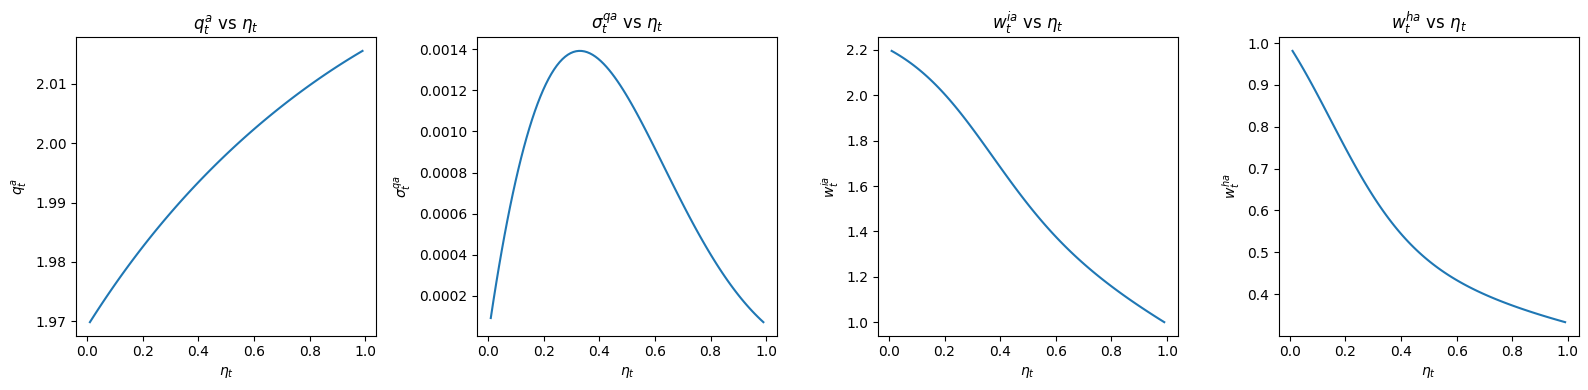

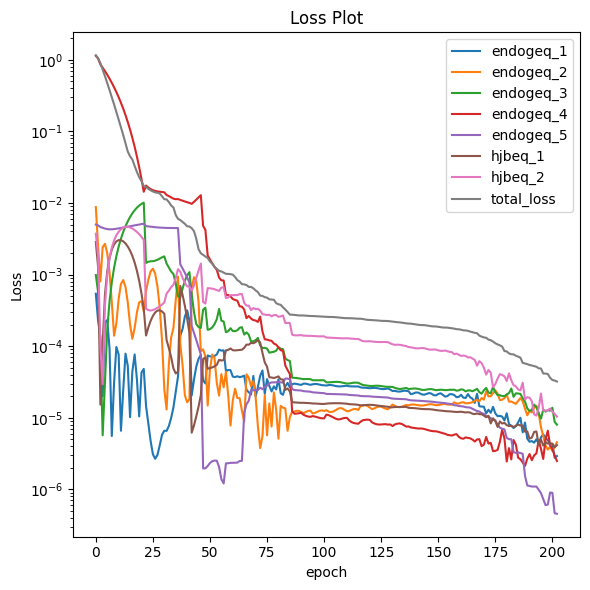

In [6]:
pde_model.plot_vars([r"$q_t^a$", r"$\sigma_t^{qa}$", r"$w_t^{ia}$", r"$w_t^{ha}$"], ncols=4)
plot_loss_df(fn="./models/1d_prob_relobralo/model_min_loss.csv", loss_plot_fn="./models/1d_prob_relobralo/model_min_loss.png")

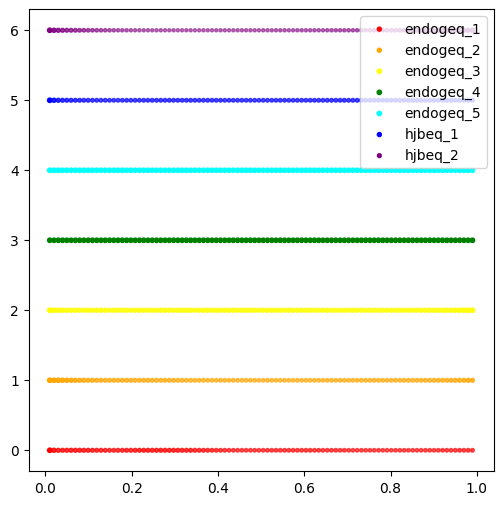

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

loss_weight_df = pd.read_csv("./models/1d_prob_soft_attention/model_loss_weight.csv")
# get the final weights
loss_weight_df = loss_weight_df[loss_weight_df["epoch"] == loss_weight_df["epoch"].max()]
columns_to_plot = list(loss_weight_df.columns)
columns_to_plot.remove("epoch")
columns_to_plot.remove("eta")
points = loss_weight_df["eta"].values
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "purple"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i, col in enumerate(columns_to_plot):
    curr_weights = np.array(loss_weight_df[col].values)
    alpha = curr_weights / np.max(curr_weights)
    y_pos = [i] * len(points)
    plt.scatter(points, y_pos, s=alpha * 10, c=colors[i], alpha=alpha, label=col)
plt.legend()
plt.show()

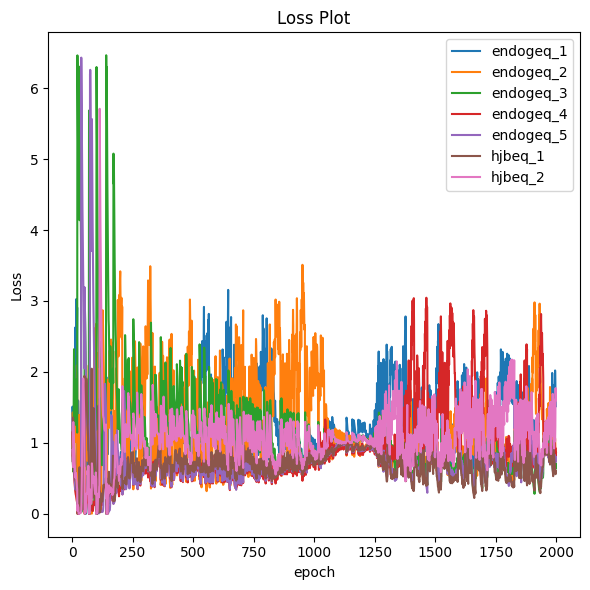

In [9]:
plot_loss_df(fn="./models/1d_prob_relobralo/model_loss_weight.csv", loss_plot_fn="./models/1d_prob_relobralo/model_loss_weight.png", log_loss=False)

Min losses:
soft attention: 2.4503196982550435e-05
with adaption: 3.2045285479398444e-05


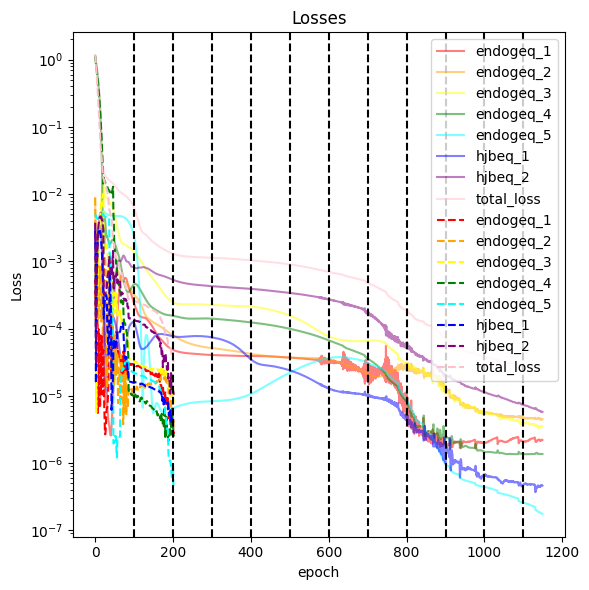

In [14]:
loss_df_soft_attention= pd.read_csv("./models/1d_prob_soft_attention/model_min_loss.csv").dropna().reset_index(drop=True)
loss_df_adaption = pd.read_csv("./models/1d_prob_relobralo/model_min_loss.csv").dropna().reset_index(drop=True)
print("Min losses:")
print("soft attention:", loss_df_soft_attention["total_loss"].min())
print("with adaption:", loss_df_adaption["total_loss"].min())
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
losses_to_plot = list(loss_df_soft_attention.columns)
losses_to_plot.remove("epoch")
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "purple", "pink"]
alphas = [0.5, 1.0]
widths = [2, 4]
linestyles = ["-", "--"]
for i, loss_df in enumerate([loss_df_soft_attention, loss_df_adaption]):
    for j, loss in enumerate(losses_to_plot):
        ax.plot(loss_df["epoch"], loss_df[loss], label=loss, color=colors[j], linestyle=linestyles[i], alpha=alphas[i])
for j in range(1, 12):
    ax.axvline(j*100, color="black", linestyle="dashed")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Losses")
plt.tight_layout()
plt.show()